# Práctico 2

In [24]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [25]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

Levanto el DataSet

In [26]:
data = pd.read_csv('datasets/demanda.csv', index_col='TIPO', parse_dates=True, dayfirst=True,thousands='.')
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2018-04-01,4084110,3131427,3277777,10493315
2018-05-01,4276830,3101854,3286778,10665462
2018-06-01,5569775,3231036,3123287,11924098
2018-07-01,6167114,3326186,3112541,12605842
2018-08-01,5359054,3237765,3112882,11709701


In [27]:
y = data['Comercial'].copy()
y.index = y.index.to_period(freq='M')

ts = data['Comercial']

In [28]:
data.describe().round(2)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,44.00,44.00,44.00,44.00
mean,4745018.02,3193531.25,3201238.93,11139788.20
std,627095.26,193716.15,107030.91,764343.47
min,3754330.00,2900824.00,2950818.00,9793759.00
25%,4222957.00,3038991.25,3122472.25,10466094.50
50%,4715575.50,3151394.50,3215652.00,11126247.50
75%,5201443.25,3312377.75,3266523.25,11800556.25
max,6167114.00,3670275.00,3460880.00,12605842.00


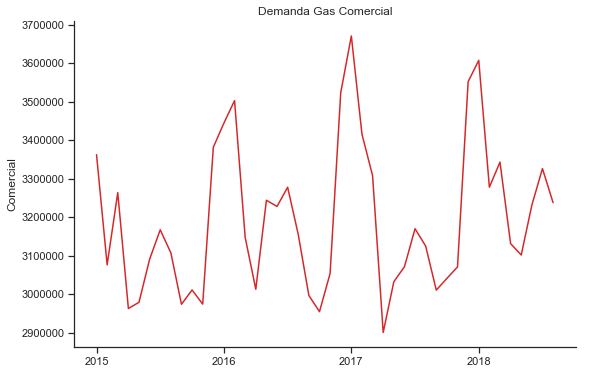

In [29]:
fig, ax= plt.subplots(figsize=(9,6))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Comercial')
ax.set_title('Demanda Gas Comercial')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

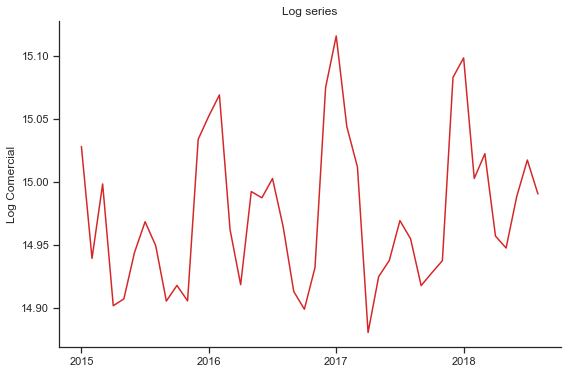

In [30]:
fig, ax= plt.subplots(figsize=(9,6))
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log Comercial')
ax.set_title('Log series')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## Time series decomposition


In [31]:
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')

C:\Users\lgrando\AppData\Local\conda\conda\envs\diplodatos-ayv\lib\site-packages\statsmodels\tsa\x13.py:182: X13Warning: NOTE: Insufficient data to compute average forecast error diagnostic.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


In [32]:
dir(decomposition)[-6:]

['observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

For example, if we want to retrieve and plot the seasonally adjusted component, we can do as follows.

In [33]:
decomposition.seasadj.tail()

TIPO
2018-04-01    3.289149e+06
2018-05-01    3.222130e+06
2018-06-01    3.264163e+06
2018-07-01    3.281491e+06
2018-08-01    3.277548e+06
Name: seasadj, dtype: float64

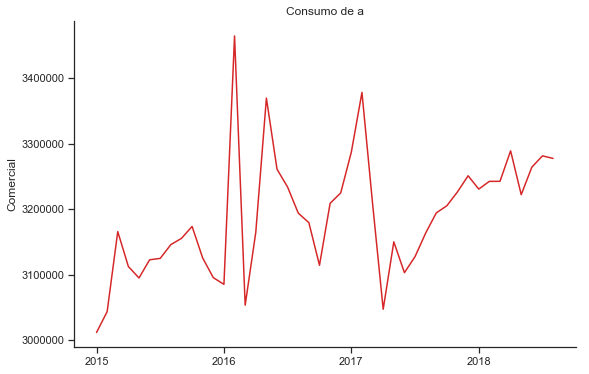

In [34]:
fig, ax= plt.subplots(figsize=(9,6))
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Comercial')
ax.set_title('Consumo de a')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

The <TT>plotting</TT> module has a convenient function for plotting the components. 

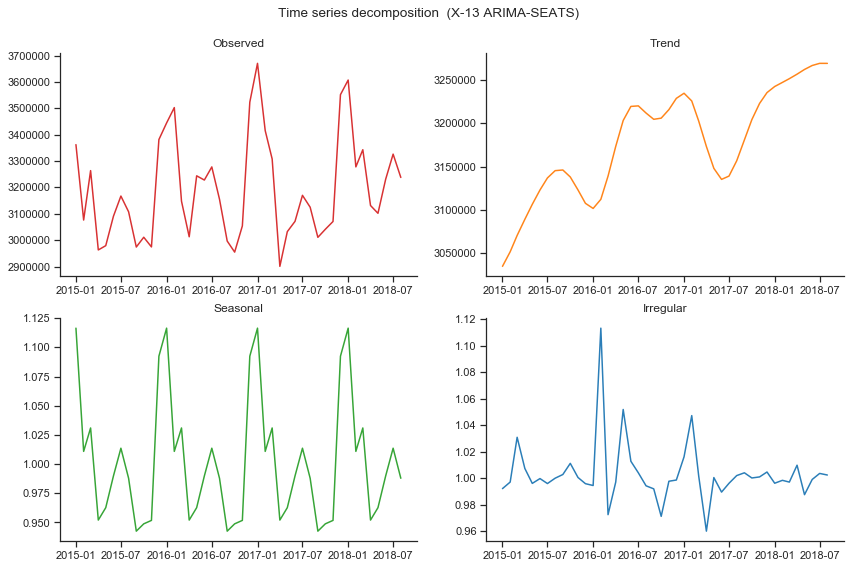

In [35]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

The X-13-ARIMA software generates a very detailed analysis of the time series, which is stored in the <TT>results</TT> attribute. You can view it with the <TT>print(decomposition.results)</TT> command, but due to the length I recommend saving it to a text file and opening it elsewhere. You can do this as follows.  

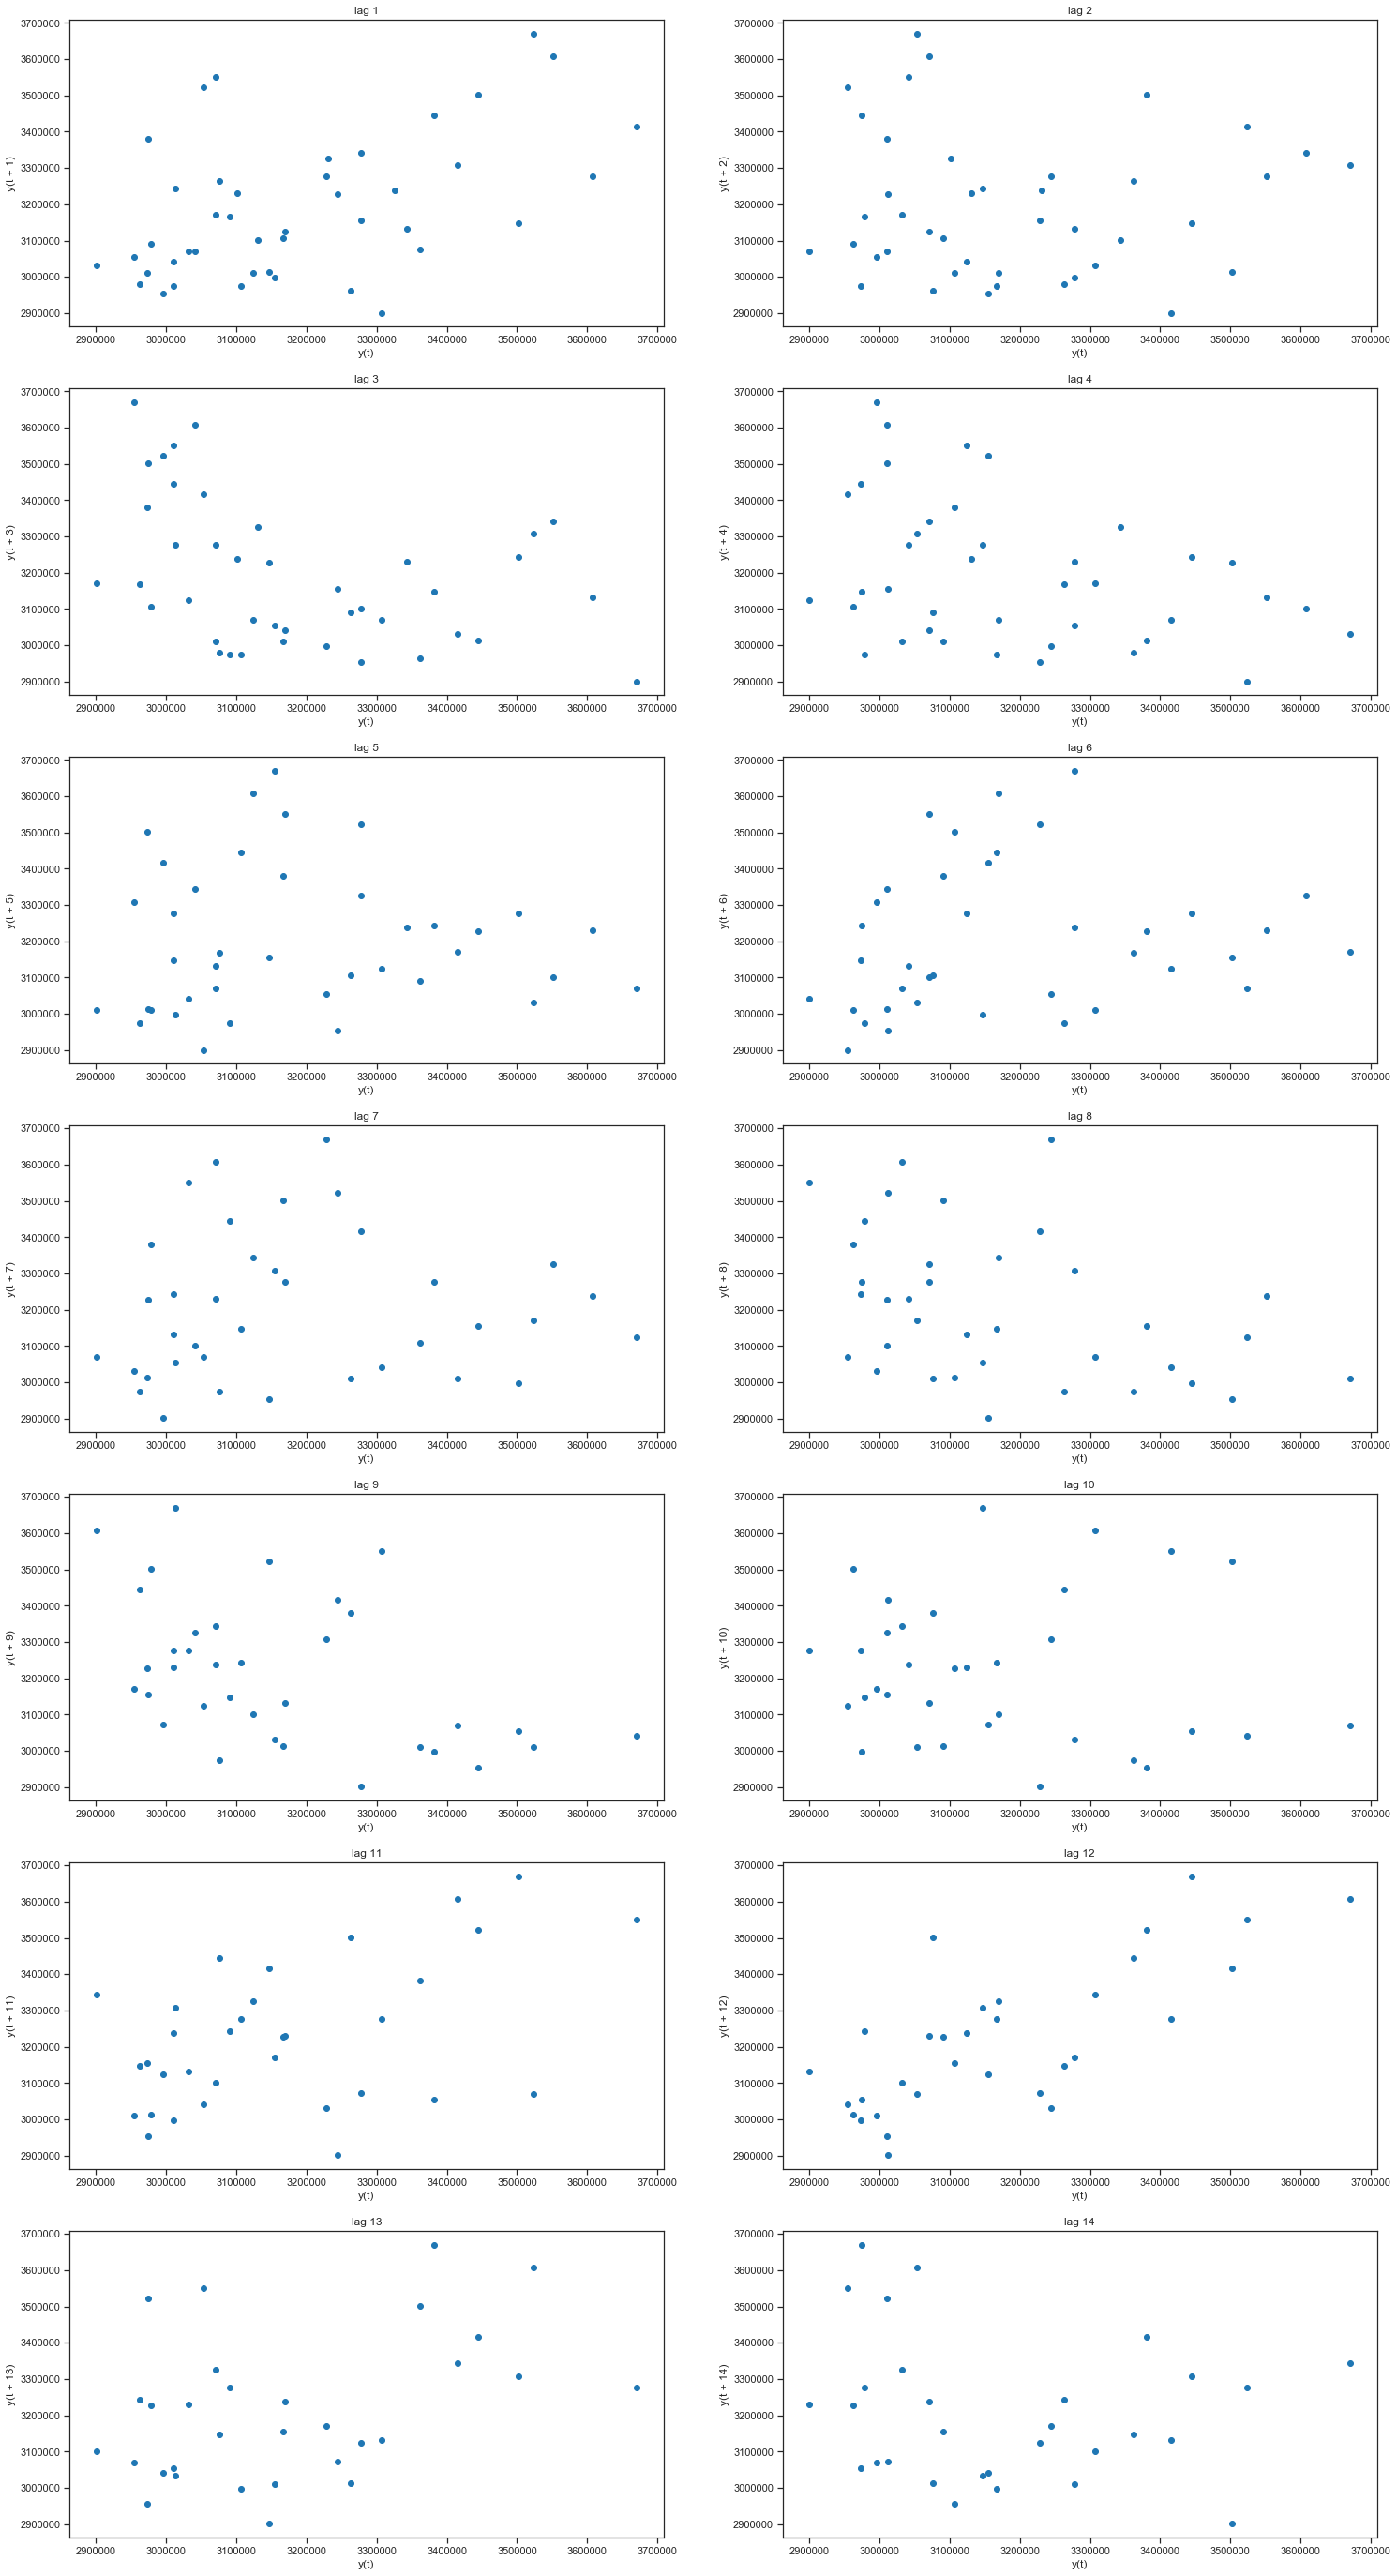

In [36]:
from pandas.plotting import lag_plot
plt.rcParams['figure.figsize'] = [25, 100]
for i in range(14):
   plt.subplot(14,2,i+1)
   plt.title("lag " + str(i+1))
   lag_plot(y,lag=i+1);

    
    La estacionalidad si bien no es muy marcada es de 12 meses

## Holt-winters exponential smoothing

We estimate several candidate specifications below.  The AIC suggests a multiplicative model without damping for the original series, but we would need to make a likelihood adjustment or a validation set comparison to selected between this method and an additive model for a log transformation. 

In [49]:
def hw_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return rmse_sm

In [50]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()

In [51]:
hw_summary(ahw_sm);

 Smoothing parameter: alpha  0.222
 Smoothing parameter: betha  0.000
 Smoothing parameter: delta  0.000
 In-sample fit:
 MSE               6022278429.180
 RMSE               77603.340


In [53]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_sm);

 Smoothing parameter: alpha  0.236
 Smoothing parameter: betha  0.000
 Smoothing parameter: delta  0.000
 In-sample fit:
 MSE               5674926689.692
 RMSE               75332.109


In [56]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=12).fit()
hw_summary(mhw_damped);

 Smoothing parameter: alpha  0.053
 Smoothing parameter: betha  0.053
 Smoothing parameter: delta  0.263
 In-sample fit:
 MSE               7208344548.657
 RMSE               84901.970


In [58]:
ahw_log_sm=sm.tsa.ExponentialSmoothing(np.log(y), trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
hw_summary(ahw_log_sm);

 Smoothing parameter: alpha  0.000
 Smoothing parameter: betha  0.000
 Smoothing parameter: delta  0.000
 In-sample fit:
 MSE               0.001
 RMSE               0.023


### El mejor modelo es el multiplicativo

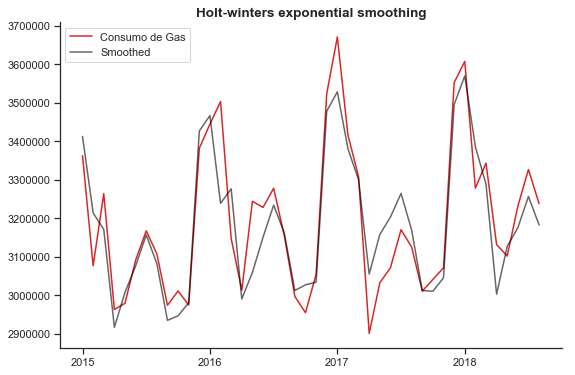

In [67]:
smoothed=pd.Series(mhw_damped.fittedvalues, index=y.index)

fig, ax= plt.subplots(figsize=(9,6))

y.plot(color='#D62728', label='Consumo de Gas')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Model diagnostics

We base the diagnostics on the multiplicative Holt-Winters model.  The model seems to adequately capture the time series patterns in the data, leading to small and insignicant residual correlations. The residuals do not follow the normal distribution, so that ideally we should use alternative assumptions for computing prediction intervals. 

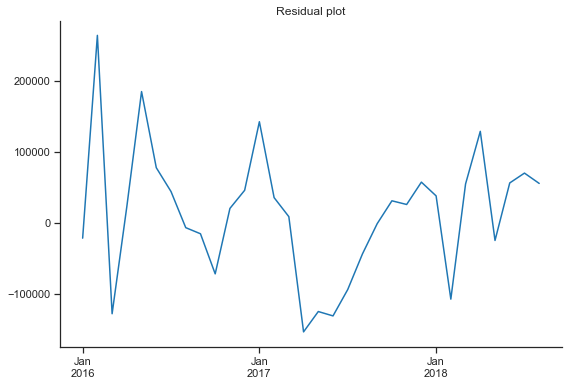

In [68]:
resid = (y-mhw_damped.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

C:\Users\lgrando\AppData\Local\conda\conda\envs\diplodatos-ayv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


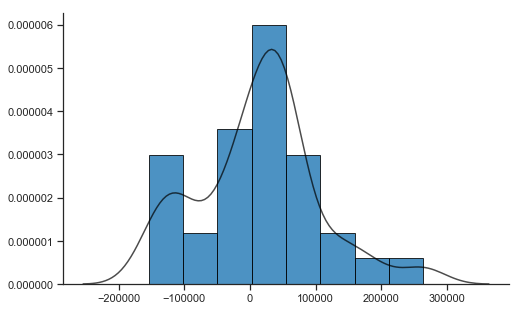

In [65]:
from plotting import histogram

histogram(resid)
plt.show()


## Model validation

The real time forecasting analysis suggests that the log additive Holt Winters model for the log series is the most accurate method for one step ahead forecasts. The Holt-Winters forecasts perform significantly better than a seasonal random walk. 

In [74]:
# Real time forecasting 

ts=np.log(y) # log series for the log-additive model

validation=y['2017-01':].index
start = y.index.get_loc('2017-01') 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
pred4 = [] # log additive holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(ts.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    resid = (ts.iloc[:i]-model.fittedvalues)[12:] # residuals
    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred4.append(y_pred) # long additive holt winters forecast

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Log additive', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [75]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(4):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,128880.335,29227.499
Additive,106958.536,24034.515
Multiplicative,114035.164,25416.469
Log additive,110074.330,24674.640


## Forecast

Se proyectan 2 Años 

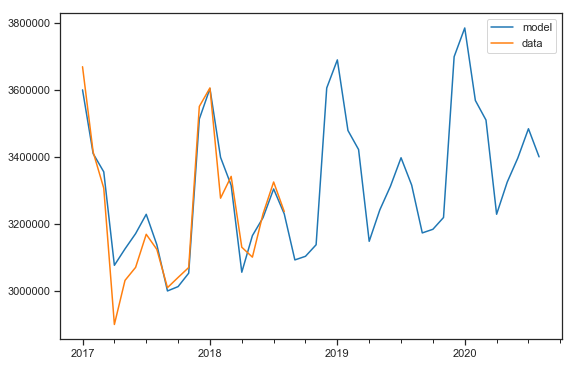

In [76]:
h=24

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()

forecast = model.forecast(h)

plot = pd.DataFrame()
plot['model'] = pd.concat([model.fittedvalues, forecast])
plot['data'] = y
#pd.Series(model.fittedvalues + model.fcastvalues), 
#                         index=pd.period_range(y.index[0],y.index[-1]+h,freq=y.index.freq))

plot['2017':].plot(figsize=(9,6));